# Sewing band structure by subduced representation

## Load modules and prepare functions

In [1]:
from __future__ import annotations

from pathlib import Path
import warnings
from itertools import product
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns

import phonopy
import seekpath
import numpy as np
import networkx as nx

import spgrep_modulation
from spgrep.group import get_little_group
from spgrep.representation import get_character
from spgrep_modulation.modulation import Modulation

%matplotlib inline

print(f"spgrep_modulation=={spgrep_modulation.__version__}")
print(f"phonopy=={phonopy.__version__}")

spgrep_modulation==0.1.dev33+gc7ed76b.d20220823
phonopy==2.16.3


In [2]:
sns.set_context("poster")
warnings.simplefilter("ignore")

In [3]:
@dataclass
class BandNode:
    """Each point in band structure, characterized by eigenvalue and character of irrep."""

    qpoint: NDArrayFloat
    character: NDArrayComplex
    eigenvalue: float
    frequency: float
    degeneracy: int


@dataclass
class QpointInfo:
    """Container for little co-group at qpoint."""

    qpoint: NDArrayFloat
    little_rotations: NDArrayInt
    little_translations: NDArrayFloat
    nodes: list[BandNode]

    @classmethod
    def from_modulation(cls, md: Modulation):
        nodes = []
        for eigenvalue, _, irrep in md.eigenspaces:
            degeneracy = irrep.shape[1]
            character = get_character(irrep)
            nodes.append(
                BandNode(
                    qpoint=md.qpoint,
                    character=character,
                    eigenvalue=eigenvalue,
                    frequency=md.eigvals_to_frequencies(eigenvalue),
                    degeneracy=degeneracy,
                )
            )

        return cls(
            qpoint=md.qpoint,
            little_rotations=md.little_rotations,
            little_translations=md.little_translations,
            nodes=nodes,
        )


def enumerate_non_overlapped_paths(
    adj_: dict[Any, list[Any]], source: Any, destination: Any
) -> list[list[Any]]:
    adj = adj_.copy()
    all_paths = []
    while len(adj[source]) > 0:
        path = []
        head = source
        while (head != destination) and (len(adj[head]) > 0):
            path.append(head)
            head = adj[head].pop()
        all_paths.append(path[1:])  # Ignore source

    return all_paths


def _saw_consecutive(
    qpoint_info1: QpointInfo,
    qpoint_info2: QpointInfo,
    num_atoms: int,
    decimals=3,
) -> list[tuple[int, int]]:
    """Connect nodes in consecutive qpoints.

    Assume little group of `qpoint_info1` includes little group of `qpoint_info2`.

    Parameters
    ----------
    qpoint_info1: QpointInfo
    qpoint_info2: QpointInfo

    Returns
    -------
    connections:
        Let `connections[i] = (n1, n2)`. `qpoint_info1.nodes[n1]` and `qpoint_info2.nodes[n2]` are connected.
    """
    graph = nx.DiGraph()
    num_nodes1 = len(qpoint_info1.nodes)
    num_nodes2 = len(qpoint_info2.nodes)
    graph.add_nodes_from(range(num_nodes1))
    graph.add_nodes_from(range(num_nodes1, num_nodes1 + num_nodes2))

    # Retrieve subgroup of little co-group at qpoint-1 preserving qpoint2
    _, _, mapping = get_little_group(
        rotations=qpoint_info1.little_rotations,
        translations=qpoint_info1.little_translations,
        kpoint=qpoint_info2.qpoint,
    )

    for idx1, node1 in enumerate(qpoint_info1.nodes):
        subduced_character1 = node1.character[mapping]
        for offset, node2 in enumerate(qpoint_info2.nodes):
            idx2 = num_nodes1 + offset
            count = np.sum(np.conj(subduced_character1) * node2.character) / len(mapping)
            count = np.around(np.real(count)).astype(int)
            if count >= 1:
                # Work around to stop min-cost-flow algorithm
                weight = abs(node1.eigenvalue - node2.eigenvalue)
                weight = int(weight * (10**decimals))
                capacity = min([node1.degeneracy, node2.degeneracy, count])
                graph.add_edge(idx1, idx2, weight=weight, capacity=capacity)

    # Add source and destination to solve as min-cost flow
    source = num_nodes1 + num_nodes2
    destination = source + 1
    demand = 3 * num_atoms  # Number of branches
    graph.add_node(source, demand=-demand)
    graph.add_node(destination, demand=demand)
    for idx1, node1 in enumerate(qpoint_info1.nodes):
        graph.add_edge(source, idx1, weight=0, capacity=node1.degeneracy)
    for offset, node2 in enumerate(qpoint_info2.nodes):
        idx2 = num_nodes1 + offset
        graph.add_edge(idx2, destination, weight=0, capacity=node2.degeneracy)

    assert sum([node.degeneracy for node in qpoint_info1.nodes]) == demand
    assert sum([node.degeneracy for node in qpoint_info2.nodes]) == demand
    flowdict = nx.min_cost_flow(graph)

    # Recover matching
    active_edges = {}
    for src, dst_flow in flowdict.items():
        for dst, flow in dst_flow.items():
            if src in active_edges:
                active_edges[src].extend([dst for _ in range(flow)])
            else:
                active_edges[src] = [dst for _ in range(flow)]
    all_paths = enumerate_non_overlapped_paths(active_edges, source, destination)

    connections = []
    for idx1, idx2 in all_paths:
        connections.append((idx1, idx2 - num_nodes1))
    return connections


def sew_bands(
    ph: phonopy.Phonopy,
    start: list[float],
    stop: list[float],
    num: int = 17,
):
    """Connect bands between qpoints `start` and `stop`.

    Returns
    -------
    list_qpoint_info: list[QpointInfo]
    connections: list[list[tuple[int, int]]]
        list with length = 3 * len(ph.primitive)
        connections[k] is the k-th band composed of list of tuples `(i, idx)` corresponding to `list_qpoint_info[i].nodes[idx]`
    ratios: array with shape (num, )
    """
    if num <= 2:
        raise ValueError("Specify more than three points for `num`.")

    list_qpoint_info = []
    ratios = np.linspace(0, 1, num=num, endpoint=True)
    for ratio in ratios:
        qpoint = np.array(start) * (1 - ratio) + np.array(stop) * ratio
        md = Modulation.with_supercell_and_symmetry_search(
            dynamical_matrix=ph.dynamical_matrix,
            supercell_matrix=[1, 1, 1],  # No need to care about being commensurate here
            qpoint=qpoint,
            factor=ph.unit_conversion_factor,
        )
        info = QpointInfo.from_modulation(md)
        list_qpoint_info.append(info)

    # Connect between consecutive qpoints
    all_paths = []
    num_atoms = len(ph.primitive)
    for i in range(num - 2):
        for n1, n2 in _saw_consecutive(list_qpoint_info[i], list_qpoint_info[i + 1], num_atoms):
            all_paths.append(((i, n1), (i + 1, n2)))
    for n2, n1 in _saw_consecutive(list_qpoint_info[-1], list_qpoint_info[-2], num_atoms):
        # Reverse the last path
        all_paths.append(((num - 2, n1), (num - 1, n2)))

    adj = {}
    for i, info in enumerate(list_qpoint_info):
        for idx in range(len(info.nodes)):
            adj[(i, idx)] = []
    for src, dst in all_paths:
        adj[src].append(dst)

    # Add dummy source and destination nodes
    source = "source"
    destination = "destination"
    adj[source] = []
    adj[destination] = []
    for idx, node in enumerate(list_qpoint_info[0].nodes):
        adj[source].extend([(0, idx) for _ in range(node.degeneracy)])
    for idx, node in enumerate(list_qpoint_info[-1].nodes):
        adj[(num - 1, idx)].extend([destination for _ in range(node.degeneracy)])

    connections = enumerate_non_overlapped_paths(adj, source, destination)
    return list_qpoint_info, connections, ratios

## Prepare `Phonopy` object

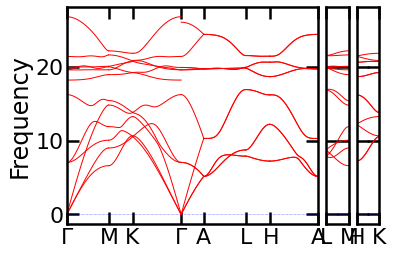

In [4]:
path = Path().resolve().parent.parent / "tests" / "phonopy_mp-661.yaml.xz"
ph = phonopy.load(path)
ph.auto_band_structure(plot=True).show()

## Sewing

In [5]:
band_path = seekpath.get_path(ph.primitive.totuple())
label1, label2 = band_path["path"][0]
list_qpoints_info, connections, ratios = sew_bands(
    ph, band_path["point_coords"][label1], band_path["point_coords"][label2], num=512
)

## Plot band structure with connection

Yellow and light blue branches seem to be mis-identified.
They have the equivalent irreps between Gamma and M points.
Thus, there is no way to distinguish them only from symmetry.

[Text(0, 0, 'GAMMA'), Text(1, 0, 'M')]

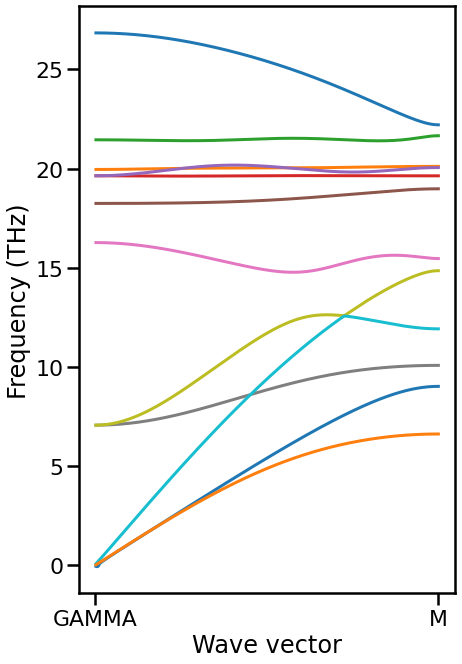

In [6]:
fig, ax = plt.subplots(figsize=(6.75, 6.75 * 1.6))
for i, (connection, ratio) in enumerate(zip(connections, ratios)):
    color = f"C{i}"
    frequencies = [
        list_qpoints_info[qpoint_idx].nodes[band_idx].frequency
        for (qpoint_idx, band_idx) in connection
    ]
    ax.plot(ratios[1:], frequencies[1:], color=color)

ax.set_xlabel("Wave vector")
ax.set_ylabel("Frequency (THz)")
ax.set_xticks([0, 1])
ax.set_xticklabels([label1, label2])

[Text(0, 0, 'GAMMA'), Text(1, 0, 'M')]

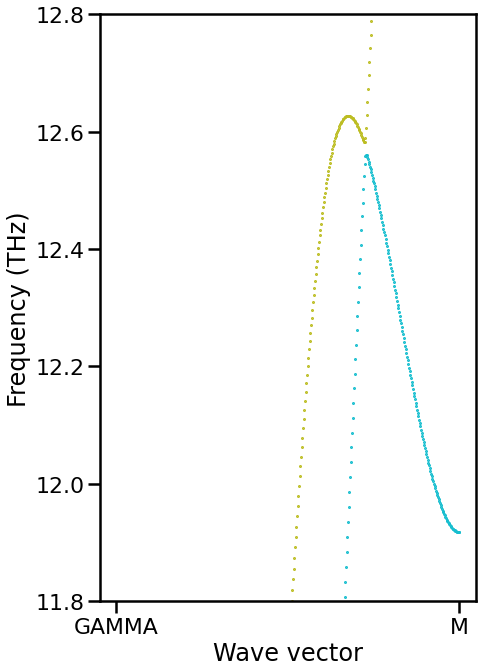

In [8]:
fig, ax = plt.subplots(figsize=(6.75, 6.75 * 1.6))
for i, (connection, ratio) in enumerate(zip(connections, ratios)):
    color = f"C{i}"
    frequencies = [
        list_qpoints_info[qpoint_idx].nodes[band_idx].frequency
        for (qpoint_idx, band_idx) in connection
    ]
    # ax.plot(ratios[1:], frequencies[1:], color=color)
    ax.scatter(ratios[1:], frequencies[1:], color=color, s=1)

ax.set_xlabel("Wave vector")
ax.set_ylabel("Frequency (THz)")
ax.set_xticks([0, 1])
ax.set_ylim(11.8, 12.8)
ax.set_xticklabels([label1, label2])